<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    System 2 - Homework 3<br>
<font color=2565AE size=5>
    Spring 2025<br>
<font color=3C99D size=5>
    LLM Agent <br>

### Full Name: Danial Parnian
---

# 🤖📘 Welcome to the *LLM + Agents* Learning Notebook!

This interactive notebook is designed to help you **build intelligent agents** that leverage the power of **Large Language Models (LLMs)** and **Vision-Language Models (VLMs)** to reason about visual data and answer questions.

---

## 🚀 What You'll Learn

✅ Load and explore a visual question answering dataset  
✅ Work with a powerful VLM (`QwenVLM`)  
✅ Build a **judge model** to assess answer correctness  
✅ Perform **zero-shot evaluation** of an LLM-based agent  
✅ ✨ **Design and implement your own agent** that can reason step-by-step  

---

You'll incrementally complete missing components in code cells, guided by clear instructions. Use your creativity to make your agent smarter!

> 💡 *Tip: Don’t hesitate to explore how prompting affects the agent’s behavior.*

---

### 🔧 Setup

Make sure you have the right environment, dependencies installed, and access to the required models.

Now, let’s start building!


# HW3 - Agents

## Load Dataset

In [2]:
!unzip agent_data.zip


Archive:  agent_data.zip
   creating: agent_data/
  inflating: agent_data/data.csv     
   creating: agent_data/images/
  inflating: agent_data/images/1018.png  
  inflating: agent_data/images/10461.png  
  inflating: agent_data/images/10546.png  
  inflating: agent_data/images/10916.png  
  inflating: agent_data/images/11286.png  
  inflating: agent_data/images/11507.png  
  inflating: agent_data/images/12013.png  
  inflating: agent_data/images/12120.png  
  inflating: agent_data/images/12394.png  
  inflating: agent_data/images/12454.png  
  inflating: agent_data/images/12758.png  
  inflating: agent_data/images/1289.png  
  inflating: agent_data/images/12902.png  
  inflating: agent_data/images/13049.png  
  inflating: agent_data/images/1307.png  
  inflating: agent_data/images/13083.png  
  inflating: agent_data/images/13489.png  
  inflating: agent_data/images/13609.png  
  inflating: agent_data/images/1365.png  
  inflating: agent_data/images/13685.png  
  inflating: agent_data/

```markdown
**Guideline:** The following code cell that loads the dataset has been removed. Please write code to:
1. Load the CSV file `agent_data/data.csv` into a pandas DataFrame.
2. Display the first few rows to verify that the data has been loaded correctly.
```

In [3]:
import pandas as pd

# Load the dataset
data = pd.read_csv('agent_data/data.csv')

# Display the first few rows of the dataset
print(data.head())

   Image                                           question  answer
0   2085  What is the shape of the object that is furthe...  square
1  14958  Is the yellow object on the top or on the bottom?  bottom
2  11507     Is the red object on the left or on the right?   right
3   5798  Is the yellow object on the left or on the right?   right
4   1289              What is the shape of the blue object?  circle


In [4]:
x = data['question'].to_list()
y = data['answer'].to_list()
image_list = data['Image'].to_list()

image_list = ['agent_data/images/'+str(i)+'.png' for i in image_list]

```markdown
**Guideline:** Please:
1. Implement a function named `show_data(i, x, y, image_list)` that:
   - Prints the question `x[i]` and its corresponding answer `y[i]`.
   - Displays the image at `image_list[i]` using `matplotlib`.
2. Call this function for index `0` to visualize a sample from the dataset.
```

What is the shape of the object that is furthest from the gray object?
square


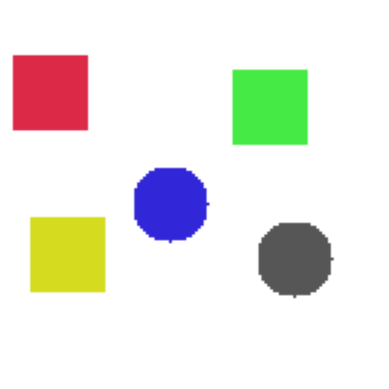

In [5]:
import matplotlib.pyplot as plt
from PIL import Image

def show_data(i, x, y, image_list):
    # Display the question and answer
    print(x[i])
    print(y[i])

    # Load and display the image
    img = Image.open(image_list[i])
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Visualize the first sample
show_data(0, x, y, image_list)

## Load LVLM

In [6]:
!pip install qwen-vl-utils[decord]==0.0.8

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 88.5 MB/s eta 0:00:00


```markdown
**Guideline:** In the following cell, you will see how to load a pretrained Vision-Language Model (VLM) using the `transformers` library and related utilities.
- Carefully read the code to understand:
  1. How the model and processor are initialized.
  2. How input images and prompts are preprocessed.
  3. How `model.generate` is used to produce text outputs.
- Be prepared to explain:
  - The role of `AutoProcessor` and `Qwen2_5_VLForConditionalGeneration`.
  - Why we trim generated token IDs before decoding.
```

In [7]:
import torch
from PIL import Image
from transformers import AutoProcessor, Qwen2_5_VLForConditionalGeneration
from qwen_vl_utils import process_vision_info


class QwenVLM:
    def __init__(self, model_name="Qwen/Qwen2.5-VL-3B-Instruct", device="cuda"):
        # Load the model
        self.model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
            model_name,
            torch_dtype="auto",
            device_map="auto"
        )

        # Load the processor
        self.processor = AutoProcessor.from_pretrained(model_name)

        # Set device
        self.device = device

    def inference(self, prompt="Describe this image.", image_path=None, max_new_tokens=128):
        if image_path:
            # Load image from local path
            image = Image.open(image_path).convert("RGB")

            # Construct messages in chat format with image
            messages = [
                {
                    "role": "user",
                    "content": [
                        {"type": "image", "image": image},
                        {"type": "text", "text": prompt},
                    ],
                }
            ]

            # Prepare text input
            text = self.processor.apply_chat_template(
                messages, tokenize=False, add_generation_prompt=True
            )

            # Prepare image/video inputs
            image_inputs, video_inputs = process_vision_info(messages)

            # Tokenize inputs
            inputs = self.processor(
                text=[text],
                images=image_inputs,
                videos=video_inputs,
                padding=True,
                return_tensors="pt",
            ).to(self.device)

        else:
            # Text-only mode
            messages = [
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": prompt},
                    ],
                }
            ]

            text = self.processor.apply_chat_template(
                messages, tokenize=False, add_generation_prompt=True
            )

            inputs = self.processor(
                text=[text],
                padding=True,
                return_tensors="pt",
            ).to(self.device)

        # Generate output
        generated_ids = self.model.generate(**inputs, max_new_tokens=max_new_tokens)
        generated_ids_trimmed = [
            out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
        ]

        # Decode output
        output_text = self.processor.batch_decode(
            generated_ids_trimmed,
            skip_special_tokens=True,
            clean_up_tokenization_spaces=False,
        )
        return output_text

vlm = QwenVLM()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.37k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/65.4k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.53G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/216 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/5.70k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

### Example

In [9]:
vlm.inference(image_path=image_list[0])

['The image shows five colored shapes arranged in a row from left to right:\n\n1. A red square.\n2. A green rectangle.\n3. A yellow triangle.\n4. A blue circle.\n5. A black dot.\n\nEach shape is distinct in color and form, creating a simple yet colorful composition.']

## LLM as a judge

```markdown
**Guideline:** Your task:
1. Design a prompt template that takes:
   - The question.
   - The model's answer.
   - The ground truth answer.
   And asks the LLM to determine if the model's answer implies the ground truth answer.
2. Implement `judge(vlm, question, model_answer, ground_truth)` to:
   - Construct and send your prompt to the VLM.
   - Parse the VLM's "Yes"/"No" response into a binary `1` (correct) or `0` (incorrect).
```

In [10]:
def judge(vlm, question, model_answer, ground_truth):
    prompt = (
        f"Question: {question}\n"
        f"Model's Answer: {model_answer}\n"
        f"Ground Truth: {ground_truth}\n"
        "Answer 'Yes' or 'No': Does the model's answer imply the ground truth answer?"
    )
    # Send the prompt to the VLM and get the response
    response = vlm.inference(prompt=prompt)
    # Parse the response
    answer = response[-1].strip().lower()
    # Check if the answer is "yes" or "no"
    if "yes" in answer:
        return 1
    else:
        return 0


### Example

In [11]:

judge(vlm, "what is the shape of object?","square", "I think shape of object is square")


1

In [12]:
# In this part should check the evalution procedure with negative examples
judge(vlm, "what is the shape of object?", "square", "the object is blue")


0

## zero-shot

```markdown
**Guideline:** Implement the zero-shot evaluation loop:
1. For each index `i` in the dataset:
   - Use `vlm.inference(image_path=image_list[i], prompt=x[i])` to get the model's prediction.
   - Store the prediction in `pred`.
   - Call `judge(vlm, x[i], pred[-1], y[i])` to obtain a binary assessment of correctness.
   - Append the judge's result to `true_pred`.
2. Use `tqdm` to monitor progress.
```

In [ ]:
from tqdm import tqdm

pred = []
true_pred = []

# Loop over all samples in the dataset
for i in tqdm(range(len(x))):
    # Get model prediction for the i-th sample (image + question)
    model_output = vlm.inference(image_path=image_list[i], prompt=x[i])
    # Store the last output (the answer)
    pred.append(model_output[-1])
    # Print model's answer and ground truth answer
    print()
    print(f"Model's answer: {pred[-1]}")
    print(f"Ground truth: {y[i]}")
    # Use the judge function to assess correctness (1 = correct, 0 = incorrect)
    true_pred.append(judge(vlm, x[i], pred[-1], y[i]))


In [ ]:
# Calculate the total accuracy
accuracy = sum(true_pred) / len(true_pred)
print(f"Zero-shot accuracy: {accuracy * 100:.2f}%")

Zero-shot accuracy: 55.00%


## Build your own agent

### Classic agents

```markdown
**Guideline:**
In the following you need use classic image processing techniques using opencv packages in addition to LLMs. Your agents should be classic approaches to process images and create a appropriate prompt for LLMs.

In this section, given the constraint that agents must rely on classical approaches, your task is to implement a set of agents along with a verifier. The goal is to design a system (whether in a single execution or through a loop) that improves your VLM's ability to solve the problem.

You're free to adjust the code structure or change the number of agents depending on what your solution requires.

What's most important here is your creativity in designing the agents. For instance, you might start with an agent that detects the question type (e.g., whether it begins with "what is" or "is the"). Based on that, different agents can follow to handle specific tasks. For example, another agent might specialize in detecting object colors. By combining such agents, you can gradually build an effective system.

In [ ]:
import cv2
import numpy as np
from typing import List, Tuple, Dict

def agent1_shape(image_path: str) -> List[str]:
    """
    Detects shapes in the image using color masks and contour approximation.
    Returns a list of detected shape names (e.g., 'square', 'circle').
    """
    img = cv2.imread(image_path)
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    shapes = []
    # Use all color masks to find all contours
    COLOR_RANGES = {
        'red': (([0, 120, 70], [10, 255, 255]), ([170, 120, 70], [180, 255, 255])),
        'green': (([36, 100, 100], [86, 255, 255]),),
        'blue': (([94, 80, 2], [126, 255, 255]),),
        'yellow': (([22, 93, 0], [45, 255, 255]),),
        'gray': (([0, 0, 40], [180, 50, 220]),),
        'black': (([0, 0, 0], [180, 255, 30]),)
    }
    for hsv_ranges in COLOR_RANGES.values():
        combined_mask = cv2.inRange(hsv_img, np.array(hsv_ranges[0][0]), np.array(hsv_ranges[0][1]))
        if len(hsv_ranges) > 1:
            for i in range(1, len(hsv_ranges)):
                mask_part = cv2.inRange(hsv_img, np.array(hsv_ranges[i][0]), np.array(hsv_ranges[i][1]))
                combined_mask = cv2.bitwise_or(combined_mask, mask_part)
        contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            if cv2.contourArea(contour) < 100:
                continue
            peri = cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, 0.04 * peri, True)
            shape = "square" if len(approx) == 4 else "circle"
            shapes.append(shape)
    return shapes

def agent2_color(image_path: str) -> List[str]:
    """
    Detects colors of objects in the image using HSV color masks.
    Returns a list of detected color names.
    """
    img = cv2.imread(image_path)
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    colors_found = []
    COLOR_RANGES = {
        'red': (([0, 120, 70], [10, 255, 255]), ([170, 120, 70], [180, 255, 255])),
        'green': (([36, 100, 100], [86, 255, 255]),),
        'blue': (([94, 80, 2], [126, 255, 255]),),
        'yellow': (([22, 93, 0], [45, 255, 255]),),
        'gray': (([0, 0, 40], [180, 50, 220]),),
        'black': (([0, 0, 0], [180, 255, 30]),)
    }
    for color, hsv_ranges in COLOR_RANGES.items():
        combined_mask = cv2.inRange(hsv_img, np.array(hsv_ranges[0][0]), np.array(hsv_ranges[0][1]))
        if len(hsv_ranges) > 1:
            for i in range(1, len(hsv_ranges)):
                mask_part = cv2.inRange(hsv_img, np.array(hsv_ranges[i][0]), np.array(hsv_ranges[i][1]))
                combined_mask = cv2.bitwise_or(combined_mask, mask_part)
        contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            if cv2.contourArea(contour) < 100:
                continue
            colors_found.append(color)
    return colors_found

def agent3_centroid(image_path: str) -> List[Tuple[int, int]]:
    """
    Calculates centroids of detected objects in the image using color masks and contour moments.
    Returns a list of (x, y) centroid coordinates.
    """
    img = cv2.imread(image_path)
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    centroids = []
    COLOR_RANGES = {
        'red': (([0, 120, 70], [10, 255, 255]), ([170, 120, 70], [180, 255, 255])),
        'green': (([36, 100, 100], [86, 255, 255]),),
        'blue': (([94, 80, 2], [126, 255, 255]),),
        'yellow': (([22, 93, 0], [45, 255, 255]),),
        'gray': (([0, 0, 40], [180, 50, 220]),),
        'black': (([0, 0, 0], [180, 255, 30]),)
    }
    for hsv_ranges in COLOR_RANGES.values():
        combined_mask = cv2.inRange(hsv_img, np.array(hsv_ranges[0][0]), np.array(hsv_ranges[0][1]))
        if len(hsv_ranges) > 1:
            for i in range(1, len(hsv_ranges)):
                mask_part = cv2.inRange(hsv_img, np.array(hsv_ranges[i][0]), np.array(hsv_ranges[i][1]))
                combined_mask = cv2.bitwise_or(combined_mask, mask_part)
        contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            if cv2.contourArea(contour) < 100:
                continue
            M = cv2.moments(contour)
            if M["m00"] == 0:
                continue
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            centroids.append((cx, cy))
    return centroids

def query_vlm(prompt: str, image_path: str) -> str:
    """
    Sends the prompt and image to the VLM and returns the first response.
    """
    return vlm.inference(image_path=image_path, prompt=prompt)[0]

def generate_prompt(prompt: str, image_path: str) -> Tuple[str, str]:
    """
    Generates a new prompt by extracting shapes, colors, and centroids from the image,
    and appending this information to the original prompt.
    Returns the new prompt and image path.
    """
    shapes = agent1_shape(image_path)
    colors = agent2_color(image_path)
    centroids = agent3_centroid(image_path)
    detected_objects = list(zip(shapes, colors, centroids))
    if not detected_objects:
        return prompt, image_path
    prompt = (
        f"Based on the following information about the objects in the image: {detected_objects}. "
        f"Please answer this question: '{prompt}'"
    )
    return prompt, image_path

def verify_response(prompt: str, image_path: str, response: str) -> bool:
    """
    Verifies if the response is appropriate for the question type (color, shape, direction, yes/no).
    Returns True if the response matches expected keywords, otherwise False.
    """
    if "color" in prompt.lower():
        colors = ["red", "blue", "green", "yellow", "black", "gray"]
        return any(color in response.lower() for color in colors)
    elif "shape" in prompt.lower():
        shapes = ["circle", "square", "triangle", "rectangle"]
        return any(shape in response.lower() for shape in shapes)
    elif any(direction in prompt.lower() for direction in ["left", "right", "top", "bottom"]):
        directions = ["left", "right", "top", "bottom"]
        return any(direction in response.lower() for direction in directions)

    return True

def agent_loop(question: str, image_path: str, max_retries=1):
    """
    Main agent loop that generates a prompt, queries the VLM, and verifies the response.
    Retries up to max_retries times if the response is not valid.
    Returns the final response.
    """
    retries = 0
    while retries < max_retries:
        prompt, image_path = generate_prompt(question, image_path)
        response = query_vlm(prompt=prompt, image_path=image_path)
        if verify_response(prompt, image_path, response):
            return response
        retries += 1
    return response

from tqdm import tqdm

pred = []
true_pred = []

for i in tqdm(range(len(x))):
    pred.append(agent_loop(image_path=image_list[i], question=x[i]))
    print()
    print(f"Model's answer: {pred[-1]}")
    print(f"Ground truth: {y[i]}")
    true_pred.append(judge(vlm, x[i], pred[-1], y[i]))

In [15]:
# Calculate the total accuracy
accuracy = sum(true_pred) / len(true_pred)
print(f"Classic agents accuracy: {accuracy * 100:.2f}%")

Classic agents accuracy: 65.00%


### Ablation Study

```markdown
In this part, you need to test the impact of each agent by removing them one by one to assess how much each contributes to the system’s accuracy. Your goal is to optimize the system and identify the most effective configuration. You should also include a written analysis explaining the role of each agent and justify why it's necessary based on its performance.

In [13]:
# Ablation: Remove agent1_shape (shapes)
def generate_prompt_no_shape(prompt: str, image_path: str) -> tuple:
    colors = agent2_color(image_path)
    centroids = agent3_centroid(image_path)
    detected_objects = list(zip(colors, centroids))
    if not detected_objects:
        return prompt, image_path
    prompt = (
        f"Based on the following information about the objects in the image: {detected_objects}. "
        f"Please answer this question: '{prompt}'"
    )
    return prompt, image_path

# Ablation: Remove agent2_color (colors)
def generate_prompt_no_color(prompt: str, image_path: str) -> tuple:
    shapes = agent1_shape(image_path)
    centroids = agent3_centroid(image_path)
    detected_objects = list(zip(shapes, centroids))
    if not detected_objects:
        return prompt, image_path
    prompt = (
        f"Based on the following information about the objects in the image: {detected_objects}. "
        f"Please answer this question: '{prompt}'"
    )
    return prompt, image_path

# Ablation: Remove agent3_centroid (centroids)
def generate_prompt_no_centroid(prompt: str, image_path: str) -> tuple:
    shapes = agent1_shape(image_path)
    colors = agent2_color(image_path)
    detected_objects = list(zip(shapes, colors))
    if not detected_objects:
        return prompt, image_path
    prompt = (
        f"Based on the following information about the objects in the image: {detected_objects}. "
        f"Please answer this question: '{prompt}'"
    )
    return prompt, image_path

def agent_loop_ablation(question, image_path, generate_prompt_func, max_retries=1):
    retries = 0
    while retries < max_retries:
        prompt, image_path = generate_prompt_func(question, image_path)
        response = query_vlm(prompt=prompt, image_path=image_path)
        if verify_response(prompt, image_path, response):
            return response
        retries += 1
    return response

from tqdm import tqdm

# Ablation 1: Without agent1_shape
pred1, true_pred1 = [], []
for i in tqdm(range(len(x)), desc="No agent1_shape"):
    pred1.append(agent_loop_ablation(x[i], image_list[i], generate_prompt_no_shape))
    true_pred1.append(judge(vlm, x[i], pred1[-1], y[i]))
acc1 = sum(true_pred1) / len(true_pred1)
print(f"Accuracy without agent1_shape: {acc1 * 100:.2f}%")

# Ablation 2: Without agent2_color
pred2, true_pred2 = [], []
for i in tqdm(range(len(x)), desc="No agent2_color"):
    pred2.append(agent_loop_ablation(x[i], image_list[i], generate_prompt_no_color))
    true_pred2.append(judge(vlm, x[i], pred2[-1], y[i]))
acc2 = sum(true_pred2) / len(true_pred2)
print(f"Accuracy without agent2_color: {acc2 * 100:.2f}%")

# Ablation 3: Without agent3_centroid
pred3, true_pred3 = [], []
for i in tqdm(range(len(x)), desc="No agent3_centroid"):
    pred3.append(agent_loop_ablation(x[i], image_list[i], generate_prompt_no_centroid))
    true_pred3.append(judge(vlm, x[i], pred3[-1], y[i]))
acc3 = sum(true_pred3) / len(true_pred3)
print(f"Accuracy without agent3_centroid: {acc3 * 100:.2f}%")

No agent1_shape: 100%|██████████| 100/100 [03:06<00:00,  1.87s/it]


Accuracy without agent1_shape: 48.00%


No agent2_color: 100%|██████████| 100/100 [03:16<00:00,  1.97s/it]


Accuracy without agent2_color: 61.00%


No agent3_centroid: 100%|██████████| 100/100 [02:50<00:00,  1.71s/it]

Accuracy without agent3_centroid: 64.00%


### DL Agents

```markdown
**Guideline:** In the Deep Learning Agents section, you will develop enhanced agents using LLM techniques. For each agent (`agent1`, `agent2`, `agent3`):
1. Modify the agent function to:
   - Here, you need to using Deep Learning techniques to build agents beside LLM.
   - Generate an intermediate reasoning step or sub-prompt via the VLM.
   - Use that reasoning to produce a final answer tuple `(intermediate, final)`.
2. Ensure that `agent_loop` integrates these steps to iteratively refine answers based on VLM feedback.

In this section, given the constraint that agents must rely on Deep Learning approaches, your task is to implement a set of agents along with a verifier. The goal is to design a system (whether in a single execution or through a loop) that improves your VLM's ability to solve the problem.

You're free to adjust the code structure or change the number of agents depending on what your solution requires.

What's most important here is your creativity in designing the agents. For instance, you might start with an agent that detects the question type (e.g., whether it begins with "what is" or "is the"). Based on that, different agents can follow to handle specific tasks. For example, another agent might specialize in instance segmentation (e.g. Segment Anything Model (SAM) model). By combining such agents, you can gradually build an effective system.
```


In [13]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-1y23je3o
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-1y23je3o
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=7d29c0ae9be5cc3b5be84c31f5f2fe62eaef13354d7781d8a59bc0ed64a31958
  Stored in directory: /tmp/pip-ephem-wheel-cache-hlq5drp5/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment_anything


In [14]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2025-06-12 15:54:33--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.37.90, 13.35.37.123, 13.35.37.84, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.37.90|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   163MB/s    in 19s     

2025-06-12 15:54:53 (127 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [ ]:
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
from PIL import Image
import numpy as np
import tempfile

def query_vlm(prompt: str, image_path: str) -> str:
    """
    Sends the prompt and image to the VLM and returns the first response.
    """
    return vlm.inference(image_path=image_path, prompt=prompt)[0]

# Initialize SAM
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
mask_generator = SamAutomaticMaskGenerator(model=sam, points_per_side=8, min_mask_region_area=100)

def agent1_segment(image_path: str):
    """Segment objects using SAM and return masks and bounding boxes."""
    image = np.array(Image.open(image_path).convert("RGB"))
    masks = mask_generator.generate(image)
    # Each mask: dict with 'segmentation', 'bbox', etc.
    return masks

def agent2_color(image_path: str, masks):
    """Classify color of each segment using VLM."""
    colors = []
    image = Image.open(image_path).convert("RGB")
    for idx, mask in enumerate(masks):
        bbox = mask['bbox']
        crop = image.crop((bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]))
        with tempfile.NamedTemporaryFile(suffix=".png", delete=True) as tmp:
            crop.save(tmp.name)
            prompt = "What is the color of the object in this image? Answer with one of the following: red, blue, green, yellow, black, gray."
            color = query_vlm(prompt=prompt, image_path=tmp.name)
            colors.append(color.strip())
    return colors

def agent3_shape(image_path: str, masks):
    """Classify shape of each segment using VLM."""
    shapes = []
    image = Image.open(image_path).convert("RGB")
    for idx, mask in enumerate(masks):
        bbox = mask['bbox']
        crop = image.crop((bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]))
        with tempfile.NamedTemporaryFile(suffix=".png", delete=True) as tmp:
            crop.save(tmp.name)
            prompt = "What is the shape of the object in this image? Answer with square or circle."
            shape = query_vlm(prompt=prompt, image_path=tmp.name)
            shapes.append(shape.strip())
    return shapes

def generate_prompt(prompt: str, image_path: str):
    """Generate prompt using detected objects' color and shape."""
    masks = agent1_segment(image_path)
    if not masks:
        return prompt, image_path
    colors = agent2_color(image_path, masks)
    shapes = agent3_shape(image_path, masks)
    detected_objects = list(zip(shapes, colors))
    prompt_full = (
        f"Based on the following detected objects (shape, color): {detected_objects}. "
        f"Please answer this question: '{prompt}'"
    )
    return prompt_full, image_path

def verify_response(prompt: str, image_path: str, response: str) -> bool:
    """Simple keyword-based verification."""
    if "color" in prompt.lower():
        colors = ["red", "blue", "green", "yellow", "black", "gray"]
        return any(color in response.lower() for color in colors)
    elif "shape" in prompt.lower():
        shapes = ["circle", "square", "triangle", "rectangle"]
        return any(shape in response.lower() for shape in shapes)
    elif any(direction in prompt.lower() for direction in ["left", "right", "top", "bottom"]):
        directions = ["left", "right", "top", "bottom"]
        return any(direction in response.lower() for direction in directions)

    return True

def agent_loop(question: str, image_path: str, max_retries=1):
    retries = 0
    while retries < max_retries:
        prompt, image_path = generate_prompt(question, image_path)
        response = vlm.inference(prompt=prompt, image_path=image_path)[0]
        if verify_response(prompt, image_path, response):
            return response
        retries += 1
    return response

from tqdm import tqdm

pred = []
true_pred = []

for i in tqdm(range(len(x))):
    pred.append(agent_loop(image_path=image_list[i], question=x[i]))
    print()
    print(f"Model's answer: {pred[-1]}")
    print(f"Ground truth: {y[i]}")
    true_pred.append(judge(vlm, x[i], pred[-1], y[i]))


In [17]:
# Calculate the total accuracy
accuracy = sum(true_pred) / len(true_pred)
print(f"DL agents accuracy: {accuracy * 100:.2f}%")

DL agents accuracy: 58.00%


### Ablation Study

```markdown
In this part, you need to test the impact of each agent by removing them one by one to assess how much each contributes to the system’s accuracy. Your goal is to optimize the system and identify the most effective configuration. You should also include a written analysis explaining the role of each agent and justify why it's necessary based on its performance.

In [18]:
import copy

# Ablation 1: Without agent1_segment (no segmentation, just use original prompt)
# This one is pointless
# def generate_prompt_no_segment(prompt: str, image_path: str):
#     # No segmentation, just use the original prompt
#     return prompt, image_path

# Ablation 2: Without agent2_color (no color, only shape)
def generate_prompt_no_color(prompt: str, image_path: str):
    masks = agent1_segment(image_path)
    if not masks:
        return prompt, image_path
    shapes = agent3_shape(image_path, masks)
    detected_objects = [(shape,) for shape in shapes]
    prompt_full = (
        f"Based on the following detected objects (shape): {detected_objects}. "
        f"Please answer this question: '{prompt}'"
    )
    return prompt_full, image_path

# Ablation 3: Without agent3_shape (no shape, only color)
def generate_prompt_no_shape(prompt: str, image_path: str):
    masks = agent1_segment(image_path)
    if not masks:
        return prompt, image_path
    colors = agent2_color(image_path, masks)
    detected_objects = [(color,) for color in colors]
    prompt_full = (
        f"Based on the following detected objects (color): {detected_objects}. "
        f"Please answer this question: '{prompt}'"
    )
    return prompt_full, image_path

def agent_loop_ablation(question: str, image_path: str, generate_prompt_func, max_retries=1):
    retries = 0
    while retries < max_retries:
        prompt, image_path = generate_prompt_func(question, image_path)
        response = query_vlm(prompt=prompt, image_path=image_path)
        if verify_response(prompt, image_path, response):
            return response
        retries += 1
    return response

from tqdm import tqdm

# Ablation 1: No segmentation
# pred_no_segment, true_pred_no_segment = [], []
# for i in tqdm(range(len(x)), desc="No agent1_segment"):
#     pred_no_segment.append(agent_loop_ablation(x[i], image_list[i], generate_prompt_no_segment))
#     true_pred_no_segment.append(judge(vlm, x[i], pred_no_segment[-1], y[i]))
# acc_no_segment = sum(true_pred_no_segment) / len(true_pred_no_segment)
# print(f"Accuracy without agent1_segment (SAM): {acc_no_segment * 100:.2f}%")

# Ablation 2: No color
pred_no_color, true_pred_no_color = [], []
for i in tqdm(range(len(x)), desc="No agent2_color"):
    pred_no_color.append(agent_loop_ablation(x[i], image_list[i], generate_prompt_no_color))
    true_pred_no_color.append(judge(vlm, x[i], pred_no_color[-1], y[i]))
acc_no_color = sum(true_pred_no_color) / len(true_pred_no_color)
print(f"Accuracy without agent2_color: {acc_no_color * 100:.2f}%")

# Ablation 3: No shape
pred_no_shape, true_pred_no_shape = [], []
for i in tqdm(range(len(x)), desc="No agent3_shape"):
    pred_no_shape.append(agent_loop_ablation(x[i], image_list[i], generate_prompt_no_shape))
    true_pred_no_shape.append(judge(vlm, x[i], pred_no_shape[-1], y[i]))
acc_no_shape = sum(true_pred_no_shape) / len(true_pred_no_shape)
print(f"Accuracy without agent3_shape: {acc_no_shape * 100:.2f}%")

No agent2_color: 100%|██████████| 100/100 [10:32<00:00,  6.33s/it]


Accuracy without agent2_color: 62.00%


No agent3_shape: 100%|██████████| 100/100 [11:23<00:00,  6.83s/it]

Accuracy without agent3_shape: 54.00%


## 🎯 Final Educational Objectives

In the final step, you should present your analysis by comparing the zero-shot approach with the two agent-driven systems you've built. Your comparison should cover not only the final accuracy but also other factors like execution time.


\begin{array}{lcc}
\textbf{Method} & \textbf{Accuracy} & \textbf{Time (100\ samples)} \\
\hline
\text{Zero-shot} & 55\% & 2{:}23 \\
\text{Classic Agents} & 65\% & 3{:}34 \\
\text{DL Agents} & 58\% & 15{:}37 \\
\end{array}


Classic Agents Ablation
- No agent1_shape: 48% (3:06)
- No agent2_color: 61% (3:16)
- No agent3_centroid: 64% (2:50)

DL Agents Ablation
- No agent2_color: 62% (10:32)
- No agent3_shape: 54% (11:23)
- No agent1_segment: Not meaningful (segmentation is essential)

Accuracy: Classic agents outperform both zero-shot and DL agents, achieving the highest accuracy (65%). DL agents show only a modest improvement over zero-shot (58% vs. 55%), despite much longer execution time.

Execution Time: Zero-shot is fastest. Classic agents add moderate overhead for image processing. DL agents are significantly slower due to segmentation and multiple VLM calls.

Ablation Insights: In classic agents, removing shape detection (agent1_shape) causes the largest drop in accuracy, showing its critical role. Color detection (agent2_color) is also important, but less so than shape. Centroid information (agent3_centroid) has the least impact.

For DL agents, the shape detection component contributes positively to performance, while the color detection agent does not help and even degrade results. This is likely due to the VLM's limited ability to accurately perceive colors. Incorporating a dedicated, task-specific deep learning model for color recognition could potentially improve overall performance.
Segmentation is essential for DL agents. without it, the system reverts to zero-shot performance. So I didnt include it in the ablation study.


By the end of this notebook, you will be able to:

- ✅ Understand how LLMs can act as intelligent agents.
- ✅ Apply multimodal models to structured reasoning tasks.
- ✅ Evaluate the outputs of models using self-judging agents.
- ✅ Build your **own agent pipeline** and apply intermediate reasoning steps.
- ✅ Reflect on how prompting and architecture influence results.

---

🎓 *This notebook equips you with essential skills to work on cutting-edge AI systems that combine vision, language, and planning.*
